In [1]:
#INSTALL ALL THE PIP REQUIRED PACKAGES
#pip intall -r requirements.txt
#SELECT THE VIRTUAL ENVIRONMENT AS THE NOTEBOOK KERNEL

import torch

import tensorflow as tf
import numpy as np
import cv2

import matplotlib.pyplot as plt

from DataSet import CustomDataset

2024-08-16 12:28:05.479100: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-16 12:28:05.479182: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-16 12:28:05.504998: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-16 12:28:05.572620: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-16 12:28:06.739288: W tensorflow/compiler/tf2

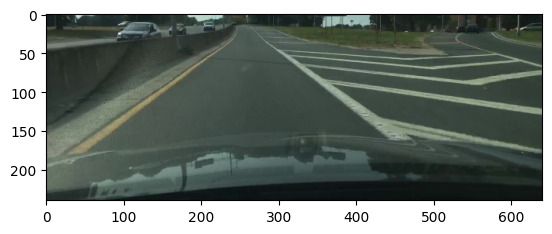

In [2]:
# SETUP INPUT
DATASET_PATH = "/media/ubuntadmin/67b3a250-6e0f-4a86-b15d-1b302250e0b4/home/ubuntadmin/Desktop/data/datasets/road-segmentation/TwinLiteTree/images"
dataset = CustomDataset(DATASET_PATH, valid=True)
img_name, input, (seg_da,seg_ll) = dataset[0]

input = torch.permute(input, (1, 2, 0))

HEIGHT_FACTOR = 2.0 / 3.0
input = input[int((1 - HEIGHT_FACTOR) * input.shape[0]) :, :, :]

image = input.clone().numpy()
plt.imshow(input)

input = input.float() / 255.0
input = input.unsqueeze(0)
input = input.numpy()

In [3]:
def run_inference(model_path: str, img: np.ndarray, delegates = []) -> tuple:
    interpreter = tf.lite.Interpreter(model_path, experimental_delegates=delegates, num_threads=4)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()[0]

    # SET TENSORS
    interpreter.set_tensor(input_details['index'], img)

    # RUN INFERENCE
    interpreter.invoke()

    # GET OUTPUT
    output_details = interpreter.get_output_details()
    return (interpreter.get_tensor(output_details[0]['index']), interpreter.get_tensor(output_details[1]['index']))

In [4]:
def qualitatif_validation(img: np.ndarray, da_predicts: np.ndarray, ll_predicts: np.ndarray):
    # DRIVABLE AREA
    da_predicts = tf.math.argmax(da_predicts[0], 2)
    img = cv2.resize(img, (da_predicts.shape[1], da_predicts.shape[0]))
    da_image = img.copy()
    da_image[da_predicts == 1] = [0,0,255]

    plt.figure()
    plt.imshow(da_image)

    # LANE LINES
    ll_predicts = tf.math.argmax(ll_predicts[0], 2)
    ll_image = img.copy()
    ll_image[ll_predicts == 1] = [0,255,0]

    plt.figure()
    plt.imshow(ll_image)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
2024-08-16 12:28:18.012249: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


(1, 240, 640, 2) (1, 240, 640, 2)


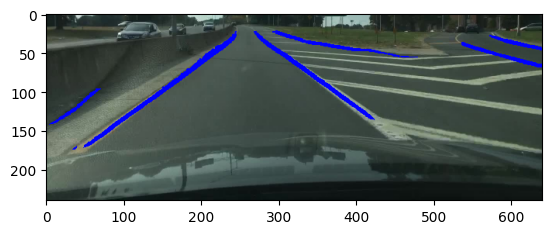

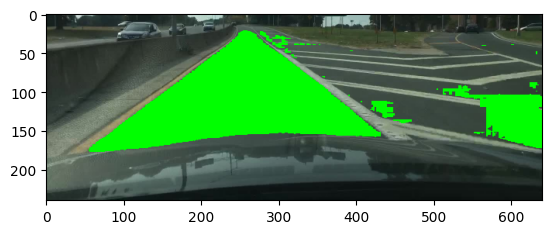

In [5]:
F32_TFLITE_MODEL_PATH="models/twinlitenet.tflite"
da_predicts, ll_predicts = run_inference(F32_TFLITE_MODEL_PATH, input)
print(da_predicts.shape, ll_predicts.shape)
qualitatif_validation(image, da_predicts, ll_predicts)

In [ ]:
I8_TFLITE_MODEL_PATH="models/twinlitenet_qt.tflite"
da_predicts, ll_predicts = run_inference(I8_TFLITE_MODEL_PATH, input)
qualitatif_validation(image, da_predicts, ll_predicts)

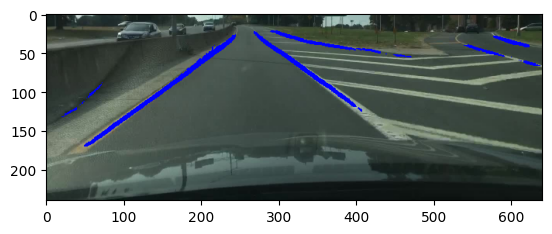

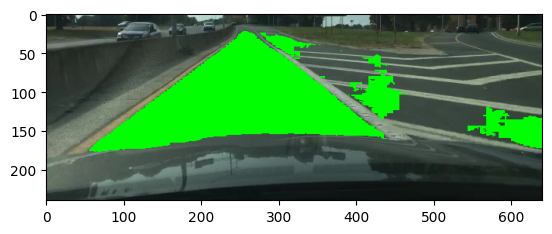

In [7]:
da_predicts, ll_predicts = run_inference("models/relu_calib1_240-640_qt.tflite", input)
qualitatif_validation(image, da_predicts, ll_predicts)